In [23]:
import sys
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import welch, spectrogram
import mne
from pathlib import Path
from mne.preprocessing import ICA
sys.path.append('D:/capachinos')
from src.eeg_analysis.preprocessing.eeg_file import EEGFile
from src.eeg_analysis.preprocessing.eeg_preprocessor import EEGPreprocessor

In [24]:
participant_id = 1
base_dir = Path(r'D:\Anesthesia_Research_Fellow') / f'CA-{participant_id:02}'
base_path = base_dir / f'CA-{participant_id:02}'

vhdr_path = base_path.with_suffix('.vhdr')
vmrk_path = base_path.with_suffix('.vmrk')
eeg_path = base_path.with_suffix('.eeg')

eeg_file = EEGFile(participant_id, str(vhdr_path), str(vmrk_path), str(eeg_path))
eeg_file.load_data()

EEG Data Shape: (10477791, 21)


#### Downsample, create epochs, bandpass filter the signal 

In [25]:
preprocessor = EEGPreprocessor(eeg_file)

target_fs = 250
window_size = 10
step_size = 5
order = 5
low_cutoff = 0.5
high_cutoff = 55
epoch_length = 30

sequence_of_operations = [
    ('downsample', {'target_fs': target_fs}),
    ('create_epochs', {'events_df': eeg_file.events_df}),
    # ('detrend', {'window_size': window_size, 'step_size': step_size}),
    # ('re_reference', {'reference_type': 'average'}),
    ('bandpass_filter', {'order': order,'low_cutoff': low_cutoff, 'high_cutoff': high_cutoff}),
    # ('exclude_noisy_periods', {'window_size':2, 'threshold':10, 'min_num_channels':1, 'padding':'zeros'})
]
preprocessor.process(sequence_of_operations)

#### Prototyping the apply_ica method
##### Analyzing and Filtering ICs: Signal Amplitude, Power Spectral Density, and Topographic Mapping

In [26]:
"""
Apply Independent Component Analysis (ICA) to the EEG data.
"""
data_attribute_to_process = 'eeg_data'
# data_attribute_to_process = 'filtered_eeg'
epoch_name = 'emergence'

data_to_process = preprocessor._check_and_get_attribute(data_attribute_to_process)
data_to_process = data_to_process[epoch_name]

# Create an MNE Info object with the properties of your data
ch_names = preprocessor.channel_names  # Update with real channel names
ch_types = ['eeg'] * 16 + ['misc'] * (data_to_process.shape[1] - 16)
sampling_freq = preprocessor.sampling_frequency
info = mne.create_info(ch_names=ch_names, sfreq=sampling_freq, ch_types=ch_types)

# Transpose your data to the shape `num_channels x num_samples` to create the Raw object
raw_data_transposed = data_to_process.T
raw = mne.io.RawArray(raw_data_transposed, info)
montage = mne.channels.make_standard_montage('standard_1020')
raw.set_montage(montage)


# Fit ICA
ica = ICA(n_components=0.95, random_state=97, method='fastica')
ica.fit(raw)


# ica.exclude = [0]  # Put the indices of components associated with eye blinks

# # Apply ICA to the Raw object to remove the components
# raw_corrected = ica.apply(raw.copy())

# # Now you can convert the data back to the original format `num_samples x num_channels`
# preprocessor.corrected_eeg[epoch_name] = raw_corrected.get_data().T

Creating RawArray with float64 data, n_channels=21, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
Fitting ICA to data using 16 channels (please be patient, this may take a while)
Selecting by explained variance: 7 components


C:\Users\Kourosh\AppData\Local\Temp\ipykernel_11916\1636398130.py:26: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Fitting ICA took 0.3s.


Method,fastica
Fit parameters,algorithm=parallelfun=logcoshfun_args=Nonemax_iter=1000
Fit,21 iterations on raw data (30000 samples)
ICA components,7
Available PCA components,16
Channel types,eeg
ICA components marked for exclusion,—


##### Temporal signal analysis

Creating RawArray with float64 data, n_channels=7, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.


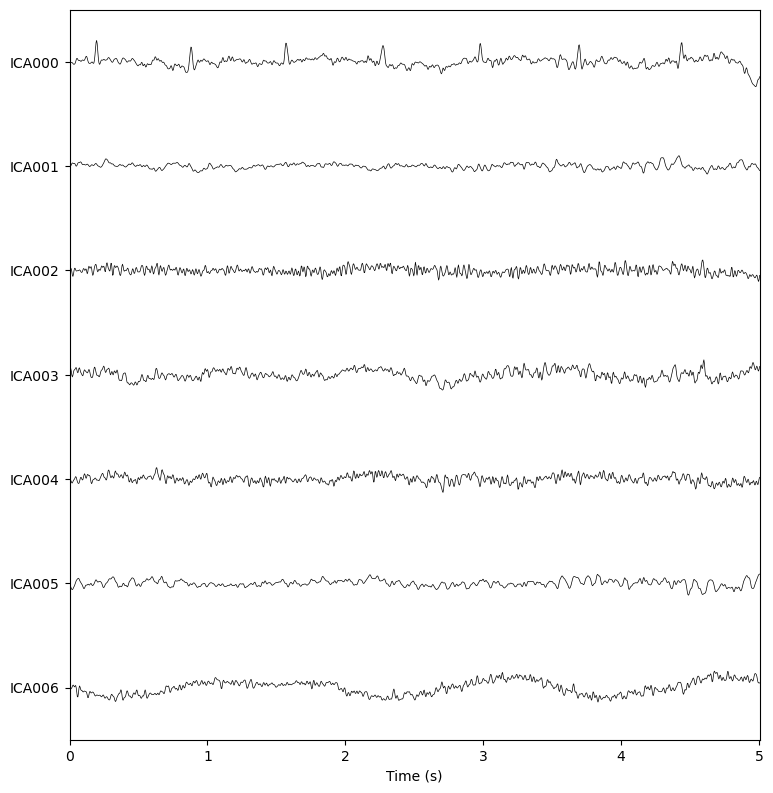

In [27]:
fig = ica.plot_sources(raw, show_scrollbars=False, start = 0, stop = 5, picks = None)

##### Power spectral density

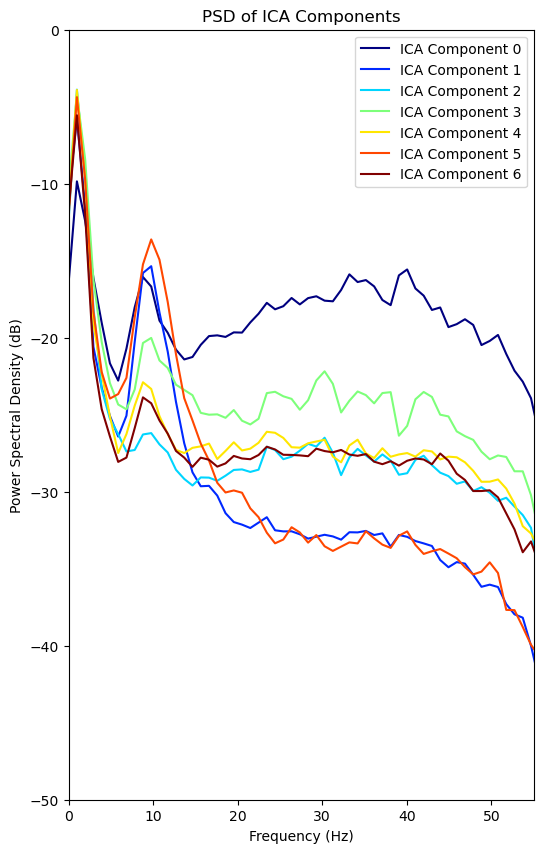

In [28]:
sources = ica.get_sources(raw).get_data().T

fig, ax = plt.subplots(figsize=[6, 10])
colors = plt.cm.jet(np.linspace(0, 1, sources.shape[1]))

for i in range(sources.shape[1]):
    freqs, psd = welch(sources[:, i], fs=sampling_freq, nperseg=256, noverlap=32) 
    ax.plot(freqs, 10 * np.log10(psd), label=f'ICA Component {i}', color=colors[i])

ax.set(title='PSD of ICA Components', xlabel='Frequency (Hz)', ylabel='Power Spectral Density (dB)')
ax.legend(loc='best')
ax.set_xlim([0, 55])  
ax.set_ylim([-50, 0]) 
plt.show()

##### Time-frequency map

C:\Users\Kourosh\AppData\Local\Temp\ipykernel_11916\1126221975.py:46: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])


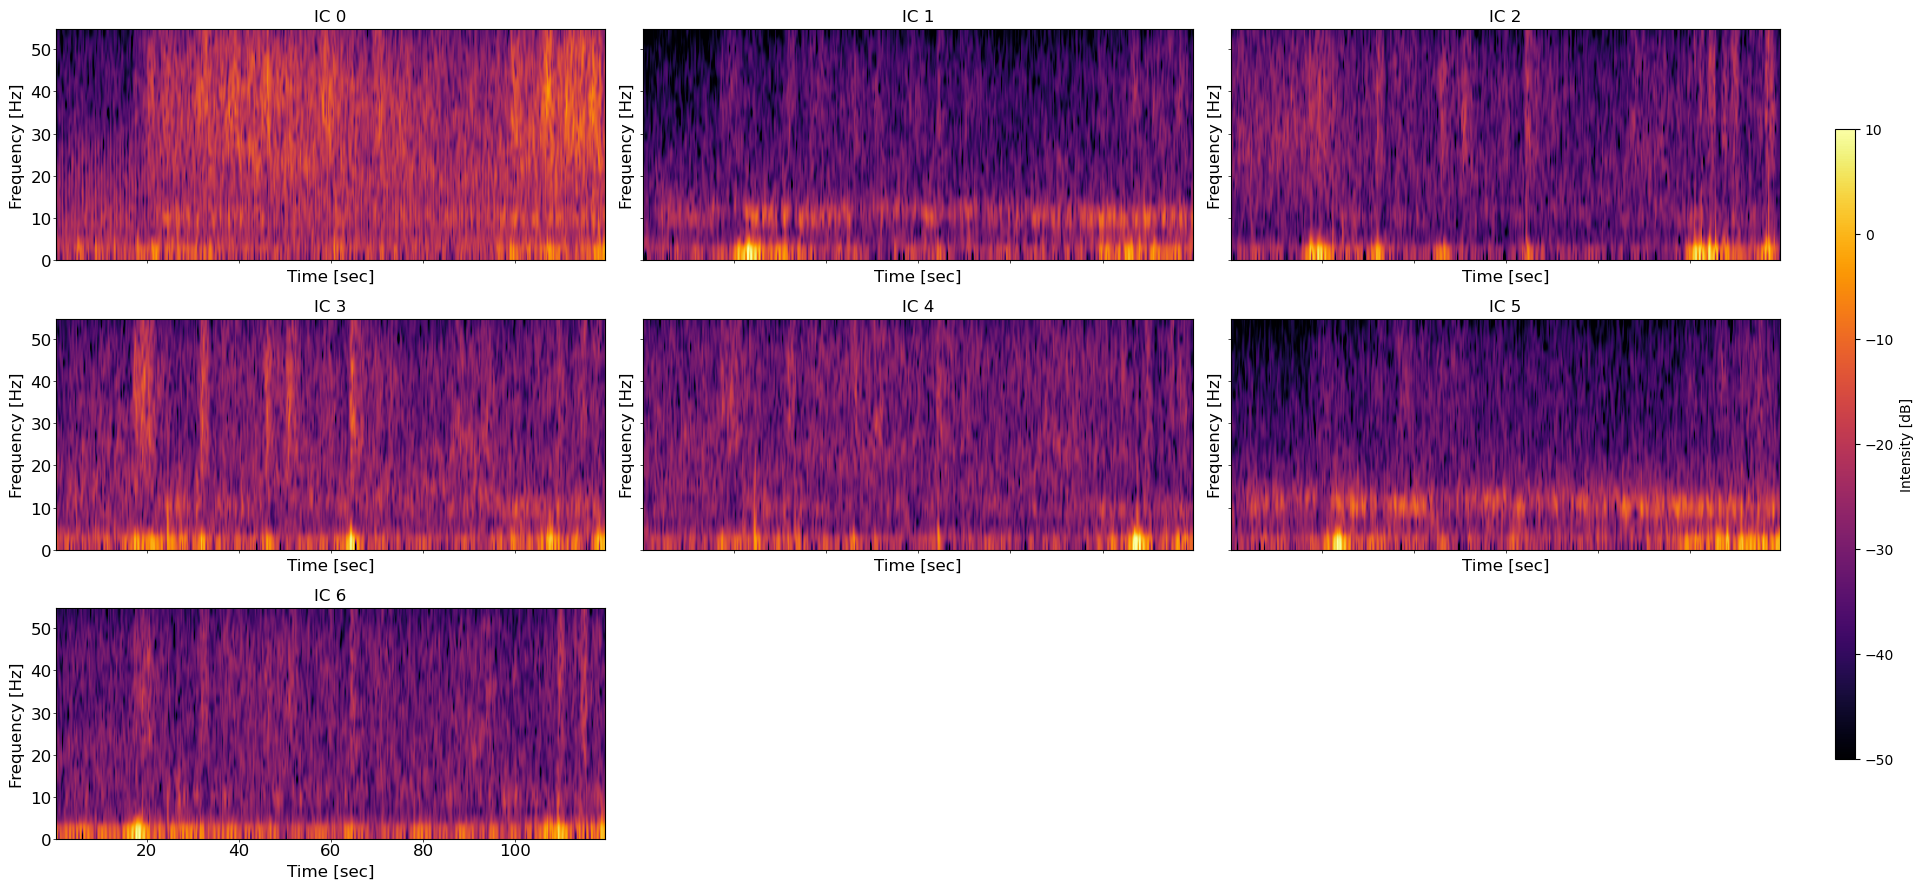

In [29]:
max_frequency = high_cutoff
sampling_freq = raw.info['sfreq']

# Get the data for all independent components
data_to_process = ica.get_sources(raw).get_data().T

n_components = data_to_process.shape[1]

n_cols = 3
n_rows = (n_components + n_cols - 1)//n_cols


fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(20, 3*n_rows), sharex=True, sharey=True)
fontsize=12
axes = axes.flatten()

for i, ax in enumerate(axes):
    if i < n_components:
            
        frequencies, times, Sxx = spectrogram(data_to_process[:, i], fs=sampling_freq, window='hann', 
                                                        nperseg=128, noverlap=64, detrend=False)

        # Set the maximum frequency for the spectrogram
        freq_index = frequencies <= max_frequency

        # Convert the power spectrogram to decibel scale
        Sxx_db = 10 * np.log10(Sxx[freq_index, :])

        # Plot the spectrogram
        im = ax.imshow(Sxx_db, aspect='auto', 
                extent=[times.min(), times.max(), frequencies[freq_index].min(), frequencies[freq_index].max()], 
                origin='lower', vmin=-50, vmax=10, cmap='inferno', interpolation='gaussian')

        # ax.set_xlim([45, 165])
        ax.set_ylabel('Frequency [Hz]', fontsize=fontsize)
        ax.set_xlabel('Time [sec]', fontsize=fontsize)
        ax.set_title(f'IC {i}', fontsize = fontsize)
    else:
        ax.axis('off')
    ax.tick_params(axis='both', which='major', labelsize=12, length=2, width=0.5, pad=1)

#color bar
cbar_ax = fig.add_axes([0.92, 0.15, 0.01, 0.7])
fig.colorbar(im, cax=cbar_ax, label='Intensity [dB]')

plt.tight_layout(rect=[0, 0, 0.9, 1])
plt.show()

##### Topography map

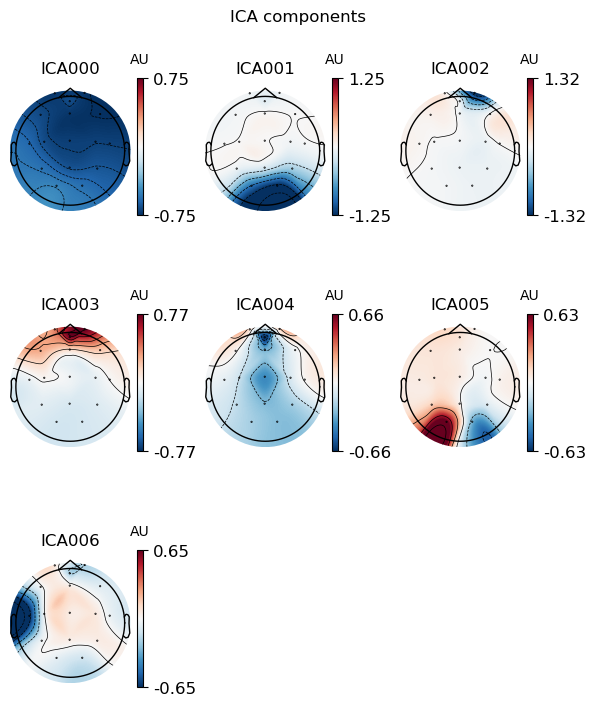

In [30]:
fig = ica.plot_components(colorbar=True, ncols=3)

#### Decompose signal using ICA, eliminate the noisy components and retirve the cleaned EEGs

In [31]:
epoch_name = 'emergence'
preprocessor.apply_ica(epoch_name, data_attribute_to_process='eeg_data')

Fitting ICA to data using 16 channels (please be patient, this may take a while)
Selecting by explained variance: 7 components


D:\capachinos\src\eeg_analysis\preprocessing\eeg_preprocessor.py:421: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Fitting ICA took 0.3s.
Applying ICA to Raw instance
    Transforming to ICA space (7 components)
    Zeroing out 1 ICA component
    Projecting back using 16 PCA components


{'emergence': array([[ 8.47809812e-07,  9.32009650e-06,  3.78245629e-06, ...,
          1.42294055e-04, -1.73114184e+01,  4.13986478e-45],
        [ 4.43042409e-06,  9.33232889e-06,  7.12236993e-06, ...,
          1.51607356e-04, -1.51096095e+01, -7.79146655e-45],
        [ 4.08833144e-06,  5.63333690e-06,  8.07971182e-06, ...,
          1.60230575e-04, -1.29118215e+01, -1.20016091e-44],
        ...,
        [ 2.95711412e-06,  3.68065801e-06, -3.39670525e-06, ...,
         -1.07738061e-04, -1.09692507e+00, -2.08486916e+00],
        [ 1.00457953e-06,  2.52457256e-06, -3.12180450e-06, ...,
          1.00878212e-03,  2.12903501e+00, -1.47126921e+00],
        [ 1.89772897e-06,  2.93692663e-06, -6.33188977e-07, ...,
          6.65228870e-04,  5.73288806e+00, -1.30943638e-02]])}

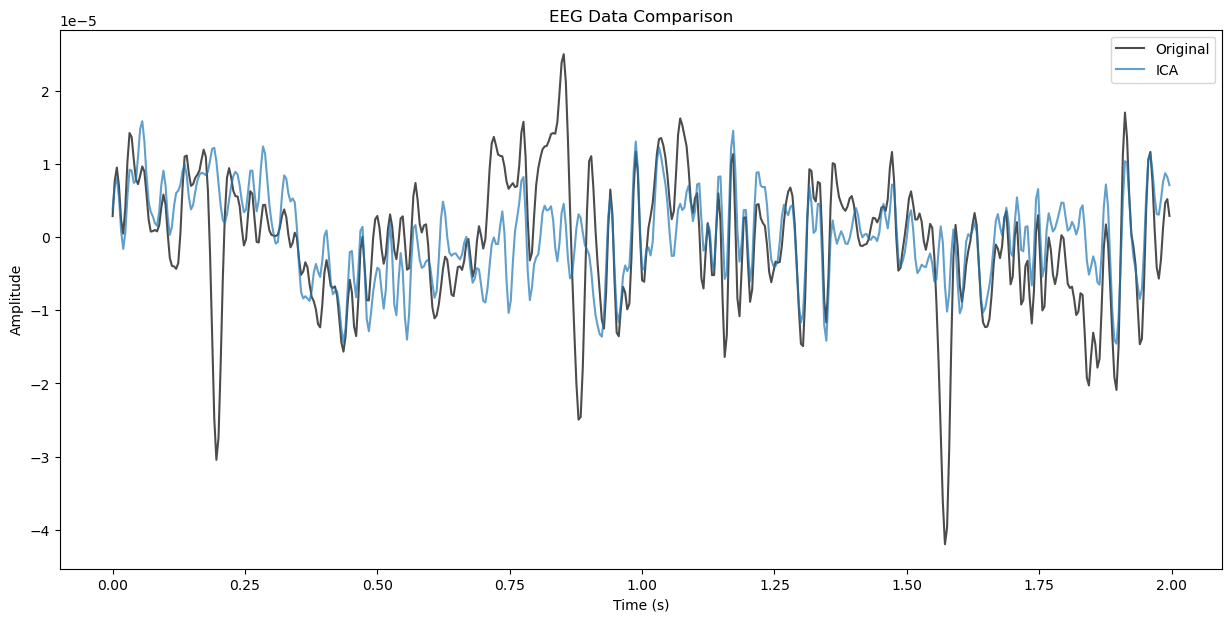

In [32]:
channel_index = 2

start_time_to_plot = 0
duration_to_plot = 2
end_time_to_plot = start_time_to_plot + duration_to_plot

original_eeg = preprocessor.eeg_data[epoch_name][int(start_time_to_plot*sampling_freq):int(end_time_to_plot*sampling_freq), :]
corrected_eeg = preprocessor.ica_corrected_eeg[epoch_name][int(start_time_to_plot*sampling_freq):int(end_time_to_plot*sampling_freq), :]

time_original = np.arange(original_eeg.shape[0]) / sampling_freq

# Plot the original EEG data
plt.figure(figsize=(15, 7))
plt.plot(time_original, original_eeg[:, channel_index], label='Original', color = 'k', alpha=0.7)

# Plot the downsampled EEG data
plt.plot(time_original, corrected_eeg[:, channel_index], label='ICA', alpha=0.7)

# plt.ylim([-5, 5])

plt.title('EEG Data Comparison')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

##### Time-frequency analysis of EEG after removing artifactual ICs

In [42]:
data_attribute_to_process = 'ica_corrected_eeg'

data_to_process = preprocessor._check_and_get_attribute(data_attribute_to_process)
data_to_process = data_to_process[epoch_name]

# Create an MNE Info object with the properties of your data
ch_names = preprocessor.channel_names  # Update with real channel names
ch_types = ['eeg'] * 16 + ['misc'] * (data_to_process.shape[1] - 16)
sampling_freq = preprocessor.sampling_frequency
info = mne.create_info(ch_names=ch_names, sfreq=sampling_freq, ch_types=ch_types)

# Transpose your data to the shape `num_channels x num_samples` to create the Raw object
raw_data_transposed = data_to_process.T
raw = mne.io.RawArray(raw_data_transposed, info)
montage = mne.channels.make_standard_montage('standard_1020')
raw.set_montage(montage)

freqs = np.logspace(*np.log10([0.5, 55]), num=50)
n_cycles = freqs / 2.  # different number of cycle per frequency
power = mne.time_frequency.tfr_multitaper(raw, freqs=freqs, time_bandwidth=6.0, n_cycles=n_cycles, use_fft=True,
                        return_itc=False, decim=3, n_jobs=1)

Creating RawArray with float64 data, n_channels=21, n_times=30000
    Range : 0 ... 29999 =      0.000 ...   119.996 secs
Ready.
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
inst is Evoked, setting `average=False`


In [ ]:
power.plot_joint(title=power.ch_names[3])